# Minicompetition Project
## Rossman 6 month sales Prediction
Here, we will go through a data challenge using data predicting Sales for Rossman. 



In [1]:
import numpy as np
import pandas as pd
from pycaret.regression import *

# 1. Initial Data Understanding
Here, we get to know our data and try to figure out next steps for modelling.

A goal in this step is to get to know what types of data cleaning, preparation and encoding we need to do in order to prepare our data for inclusion in a model.

Since we are predicting price, this is a supervised regression problem.

## visualization


In [ ]:
# plot scatter carat_weight and Price
import plotly.express as px
fig = px.scatter(x=train['Customers'], y=train['Sales'], 
                 facet_col = train['Promo'], opacity = 0.025, template = 'plotly_dark', trendline='ols',
                 trendline_color_override = 'red', title = 'CustomerBehavior - A CASE STUDY')
fig.show()

In [ ]:
# plot histogram
fig = px.histogram(train, x=["Sales"], template = 'plotly_dark', title = 'Histogram of Sales')
fig.show()

In [ ]:
# create a copy of data
data_copy = train.copy()
# create a new feature Log_Price
data_copy['Log_Price'] = np.log(train['Sales'])
# plot histogram
fig = px.histogram(data_copy, x=["Log_Price"], title = 'Histgram of Log Price', template = 'plotly_dark')
fig.show()

## Our variables



In [5]:
# PATH to Input data
PATH_TRAIN = "data/train.csv"
PATH_TEST = "data/test.csv"
PATH_STORE = "data/store.csv"
PATH_STORE_MODIFIED = "data/store_modified.csv"
MODEL_NAME = "XGBoostBasic.txt"
LABEL_ENCODE="LabelEncode"
TARGET_ENCODE="TargetEncode"
COLUMNS_NAME = "Columns_name"

## functions for wrangling and cleaning our data

In [11]:

def store_preprocess(storefile):
    # reading store_id file
    store = pd.read_csv(storefile)
    # Creating columns of competition and Promo2history with total period in months, and weeks
    store['CompetitionPeriod'] = (12-store.CompetitionOpenSinceMonth) + ((2015-store.CompetitionOpenSinceYear)*12)
    store['Promo2history'] = (52-store.Promo2SinceWeek) + ((2015-store.Promo2SinceYear)*52)
    # Dropping unnecessary columns
    store.drop(columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek', 'Promo2SinceYear'], inplace=True)
    return store

def data_preprocess(df, trainpath, store):
    # reading trainpath file
    dataframe = pd.read_csv(df)
    dataframe.replace({"StateHoliday": {0:'0'}}, inplace=True)
    # Exctraction of month and year columns in the dataframe
    def date_extraction(dataset):
            dataset['Date'] = pd.to_datetime(dataset['Date'])
            dataset['year'] = pd.DatetimeIndex(dataset['Date']).year
            dataset['month'] = pd.DatetimeIndex(dataset['Date']).month
            dataset['Day'] = dataset.Date.dt.day
            dataset['DayOfWeek'] = dataset.Date.dt.dayofweek
            dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    date_extraction(dataframe)

    # reading trainpath file
    train = pd.read_csv(trainpath)
    train.replace({"StateHoliday": {0:'0'}}, inplace=True)
    # Exctraction of month and year columns in trainpath file
    date_extraction(train)
    # Feature extraction of average customers per store, and average sales per store.
    groupy = train.groupby(['Store','month'])['Customers','Sales'].mean().rename(columns={'Customers':'CustomersAvg', 'Sales':'SalesAvg'}).reset_index()    
    # Adding feature extraction to our dataframe
    dataframe = pd.merge(dataframe, groupy,  how='inner', on=['Store','month'])
    dataframe = pd.merge(dataframe, store,  how='inner', on=['Store'])
    # Dropping unnecessary columns
    if 'Customers' in dataframe.columns:
        dataframe.drop(columns= 'Customers', inplace=True)
    dataframe.loc[:,['Promo2history']]= dataframe.loc[:,['Promo2history']].fillna(0)
    dataframe.loc[:,['CompetitionPeriod']]= dataframe.loc[:,['CompetitionPeriod']].fillna(1400)
    dataframe.loc[:,'PromoInterval']= dataframe.loc[:,'PromoInterval'].fillna('na')
    dataframe.loc[:,'CompetitionDistance']= dataframe.loc[:,'CompetitionDistance'].fillna(dataframe.CompetitionDistance.max())
    if 'Sales' in dataframe.columns:
        dataframe=dataframe.loc[dataframe['Sales']!=0]
    return dataframe



### running preprocessing on our data

In [12]:
store = store_preprocess(PATH_STORE)
train = data_preprocess(PATH_TRAIN, PATH_TRAIN, store)
holdout = data_preprocess(PATH_TEST, PATH_TRAIN, store)


store.to_csv('data/store_clean.csv')
train.to_csv('data/train_clean.csv')
holdout.to_csv('data/holdout_clean.csv')

# Model pipeline


In [14]:
# initialize setup
s = setup(data = train, session_id=42,
             train_size = 0.80,
             target = 'Sales', 
            #  fold_strategy = 'timeseries', 
             numeric_features = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'year', 
             'month', 'SalesAvg', 'CustomersAvg', 'CompetitionDistance', 
             'CompetitionPeriod', 'Promo2', 'Promo2history'], 
             categorical_features=['PromoInterval', 'Assortment', 'StoreType',  'StateHoliday'],
             fold = 3, transformation = True, 
             high_cardinality_features = ['Store'],
             numeric_imputation = 'median', categorical_imputation = "constant", feature_selection = False,
             normalize = True,  
             transform_target = True, transform_target_method='yeo-johnson',
             ignore_low_variance = True, remove_multicollinearity = True, 
             multicollinearity_threshold = 0.80, 
             remove_outliers=True)

,Description,Value
0,session_id,42
1,Target,Sales
2,Original Data,"(844338, 21)"
3,Missing Values,False
4,Numeric Features,15
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,True
8,High Cardinality Method,frequency
9,Transformed Train Set,"(641696, 39)"


In [15]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,579.5923,698420.6266,835.7113,0.9221,0.1219,0.0901,74.3567
rf,Random Forest Regressor,563.3763,707231.3580,840.9624,0.9212,0.1175,0.0856,285.6767
xgboost,Extreme Gradient Boosting,600.3913,744005.7922,862.5442,0.9171,0.1256,0.0933,62.1133
lightgbm,Light Gradient Boosting Machine,694.5545,1011554.6556,1005.7539,0.8872,0.1440,0.1076,6.4900
gbr,Gradient Boosting Regressor,800.4187,1350919.0145,1162.2682,0.8494,0.1695,0.1260,72.4900
dt,Decision Tree Regressor,801.4167,1434931.9566,1197.8701,0.8400,0.1677,0.1218,5.5233
knn,K Neighbors Regressor,867.9524,1577852.2734,1256.1065,0.8241,0.1719,0.1314,379.0967
huber,Huber Regressor,921.5895,1782155.1075,1334.9718,0.8013,0.1922,0.1453,12.2533
br,Bayesian Ridge,926.9453,1782922.7322,1335.2588,0.8012,0.1914,0.1450,2.3300
ridge,Ridge Regression,926.9437,1782900.8873,1335.2506,0.8012,0.1914,0.1450,1.0533


In [16]:
catboost_reg = create_model('catboost', fold = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,572.2063,674317.2679,821.1682,0.9256,0.1188,0.0882
1,571.9637,697169.0303,834.9665,0.9217,0.1214,0.0894
2,576.5360,700366.0146,836.8787,0.9223,0.1224,0.0898
3,572.8401,675613.5559,821.9571,0.9248,0.1222,0.0912
4,573.7423,687583.6505,829.2066,0.9231,0.1198,0.0887
5,575.6065,691290.7313,831.4390,0.9223,0.1213,0.0896
6,575.9259,690538.0457,830.9862,0.9227,0.1205,0.0893
7,576.4189,675285.3599,821.7575,0.9256,0.1201,0.0891
8,577.6309,685652.0409,828.0411,0.9234,0.1205,0.0894
9,576.5755,693627.0922,832.8428,0.9224,0.1203,0.0889


In [17]:
catboost_reg = finalize_model(catboost_reg)
save_model(catboost_reg, '2022-01-01-catboost')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['PromoInterval',
                                                             'Assortment',
                                                             'StoreType',
                                                             'StateHoliday'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['DayOfWeek', 'Open',
                                                           'Promo',
                                                           'SchoolHoliday',
                                                           'year', 'month',
                                                           'SalesAvg',
                                                           'CustomersAvg',
                                        

# Feature importance


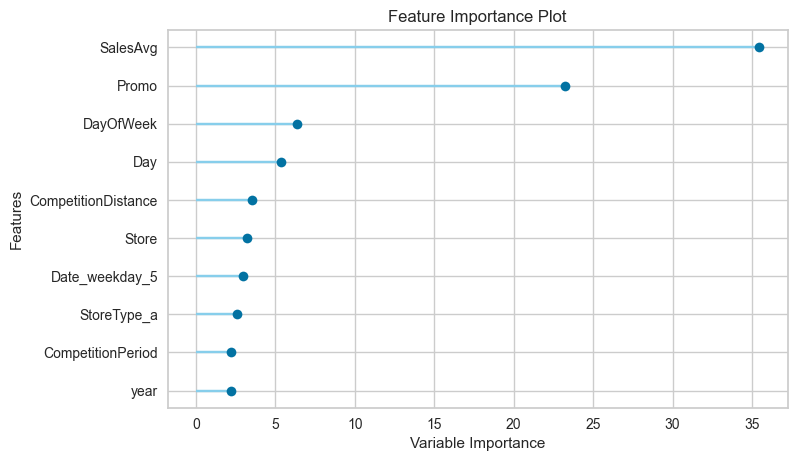

In [18]:
plot_model(catboost_reg, 'feature')

In [49]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(df_metrics.Label.values, df_metrics.Sales.values)))
print(mean_absolute_error(df_metrics.Label.values, df_metrics.Sales.values))

839.1637734919366
580.5719804579381
